In [1]:
import wfdb
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import ast
import os
import json

In [2]:
# imports for filtering

from scipy.signal import butter, lfilter, iirnotch, filtfilt
from scipy.signal import find_peaks

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Code for reading multiple signals:

In [4]:
def load_raw_data(df, sampling_rate, path, df_column):
    data = []
    labels =[]
    
    
    warning_issued = False  # flag to track if a warning has been issued
    
    if sampling_rate == 100:
        filenames = df.filename_lr
    else:
        filenames = df.filename_hr
    
    for i, row in df.iterrows():
        f = row['filename_lr'] if sampling_rate == 100 else row['filename_hr']
        
        file_path_dat = os.path.join(path, f + '.dat')
        file_path_hea = os.path.join(path, f + '.hea')
        
        if os.path.exists(file_path_dat) and os.path.exists(file_path_hea):
            signal, meta = wfdb.rdsamp(os.path.join(path, f), channels=[1])
            data.append(signal)
            labels.append(row[df_column])
        else:
            if not warning_issued:
                print("Warning: One or more files do not exist. Further missing files will not be reported.")
                warning_issued = True

    if not data:
        print("No valid data found.")
        return None

    data = np.array(data)
    return data, labels

In [5]:
# load and convert annotation data
sampling_rate=100
Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

### We need to create records100\00000\ folders in order to read multiple signals using Y 
#### - check filename_lr column of Y

In [6]:
# Y dataframe stores the address of each signal in the filename_lr column but we need to change the format of the address (for Windows)
Y['filename_lr'] = Y['filename_lr'].str.replace('/', '\\')

In [7]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# apply aggregate_diagnostic function to Y.scp_codes column
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

### X array stores the information from multiple signals and only from the first channel (lead)

In [8]:
X, labels = load_raw_data(Y, sampling_rate, os.getcwd(), 'diagnostic_superclass')

### Finding Unique Dictionaries in the "scp_codes" column

In [9]:
def remove_zero_values(d):
    """Remove key-value pairs with 0.0 value from a dictionary."""
    # since 0.0 likelihood is used for unknown likelihood
    return {k: v for k, v in d.items() if v != 0.0}

# apply this function to each dictionary in the column
Y['scp_codes'] = Y['scp_codes'].apply(remove_zero_values)

In [10]:
# Define the set of keys you are looking for
searched_keys = {'IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'LMI', 'IPLMI', 'IPMI', 'PMI'}

# Function to check if all required keys are in the dictionary
def contains_searched_keys(d):
    return any(k in d for k in searched_keys)

# Create a boolean mask
mask = Y['scp_codes'].apply(contains_searched_keys)

# Filter the DataFrame
MI_df = Y[mask]

### Filtering SCP codes that implies Myocardial Infarction:

In [11]:
scp_df = pd.read_csv('scp_statements.csv', index_col=0)

In [12]:
filter_condition = scp_df['Statement Category'] == 'Myocardial Infarction'

# Apply the filter condition to the DataFrame
scp_filtered = scp_df[filter_condition]
scp_filtered

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
ILMI,inferolateral myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferolateral myocardial infarction,NaN,NaN,NaN,NaN
AMI,anterior myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anterior myocardial infarction,160.0,NaN,NaN,NaN
ALMI,anterolateral myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anterolateral myocardial infarction,NaN,NaN,NaN,NaN
LMI,lateral myocardial infarction,1.0,NaN,NaN,MI,LMI,Myocardial Infarction,lateral myocardial infarction,163.0,NaN,NaN,NaN
IPLMI,inferoposterolateral myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferoposterolateral myocardial infarction,NaN,NaN,NaN,NaN
IPMI,inferoposterior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferoposterior myocardial infarction,NaN,NaN,NaN,NaN
PMI,posterior myocardial infarction,1.0,NaN,NaN,MI,PMI,Myocardial Infarction,posterior myocardial infarction,162.0,NaN,NaN,NaN


### Filtering rows to choose the training set

In [13]:
min_age = 20
max_age = 60

age_mask = (MI_df['age'] >= min_age) & (MI_df['age'] <= max_age)
filtered_df = MI_df[age_mask]

columns_to_remove = ['baseline_drift', 'burst_noise', 'static_noise', 'electrodes_problems', 'pacemaker', 'extra_beats', 'nurse', 'site']

# remove the specified columns
filtered_df = filtered_df.drop(columns=columns_to_remove)

# boolean mask to filter the dataframe by "age", "human validation", and "device"

filtered_df = filtered_df[filtered_df.validated_by_human == True]
filtered_df = filtered_df[filtered_df.device == 'CS100    3']
strat_fold_mask = (filtered_df['strat_fold'] < 9)
filtered_df = filtered_df[strat_fold_mask]

# filtered_df[filtered_df.sex == 1].filename_lr

### Sağlıklı insanların Verisi
#### - bu kişilere ait dosyaları veri setinden indireceğiz.

In [14]:
norm_key = {'NORM'}

# Function to check if all required keys are in the dictionary
def contains_required_keys(d):
    return norm_key.issubset(d.keys())

# Create a boolean mask
mask = Y['scp_codes'].apply(contains_required_keys)

# Filter the DataFrame
Y_norm = Y[mask]

In [15]:
norm_age_mask = (Y_norm['age'] >= min_age) & (Y_norm['age'] <= max_age)
norm_filtered = Y_norm[norm_age_mask]

# remove the specified columns
norm_filtered = norm_filtered.drop(columns=columns_to_remove)

# boolean mask to filter the dataframe by "age", "human validation", and "device"

norm_filtered = norm_filtered[norm_filtered.validated_by_human == True]
norm_filtered = norm_filtered[norm_filtered.device == 'CS100    3']
strat_fold_mask = (norm_filtered['strat_fold'] < 9)
norm_filtered = norm_filtered[strat_fold_mask]

## Pre-processing

### Pan Tompkins Algorithm:

In [16]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    n_signals, n_samples, _ = data.shape
    filtered_data = np.zeros_like(data)

    for i in range(n_signals):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')

        # apply the filter to each signal individually
        filtered_data[i, :, 0] = filtfilt(b, a, data[i, :, 0]) 
        
        # in our case X will be the input array 
        # X stores multiple signals therefore we need to index 'data' argument as data[i, :, 0]
    
    return filtered_data
fs =100
filtered_signals = bandpass_filter(X, 5, 15, fs)

In [17]:
def plot_signals(signals_array, r_peaks=None):
    
    # r_peaks is an optional argument if it is not provided the function plots only the function.
    
    n_signals, n_samples, _ = signals_array.shape

    # Create a figure with subplots
    fig, axes = plt.subplots(n_signals, 1, figsize=(10, 20))  # Adjust the size as needed

    for i in range(n_signals):
        # Plot each signal in a separate subplot
        axes[i].plot(signals_array[i, :, 0])  # Selecting the i-th signal

        # Plot R-peaks if provided
        if r_peaks is not None:
            axes[i].scatter(r_peaks[i], signals_array[i, r_peaks[i], 0], color='red')  # Plot R-peaks

        axes[i].set_title(f'Signal {i+1}')
        axes[i].set_xlabel('Sample Number')
        axes[i].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

<span style="color: red; font-size: 150%;">Signal Before Bandpass Filter</span>

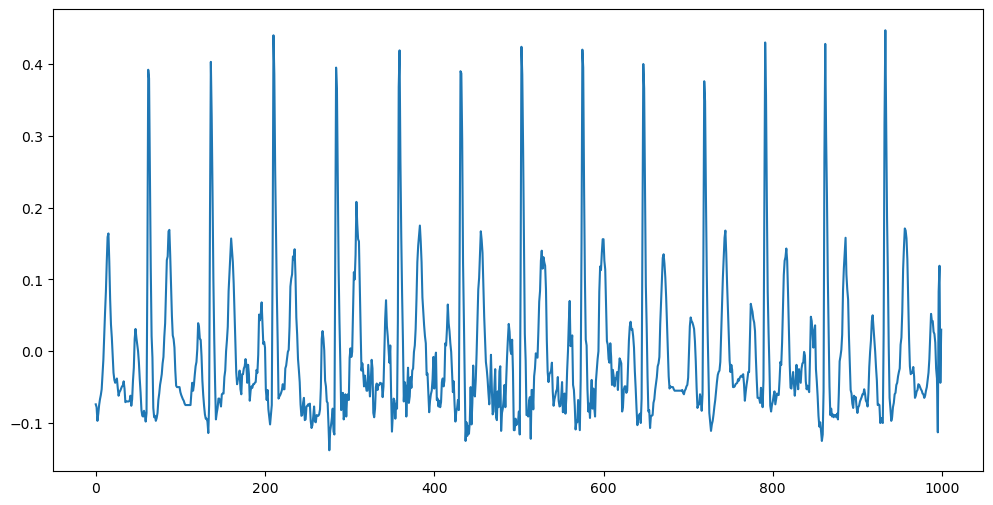

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(X[1, :, 0])
plt.show()

<span style="color: red; font-size: 150%;">Effect of the Bandpass Filter</span>

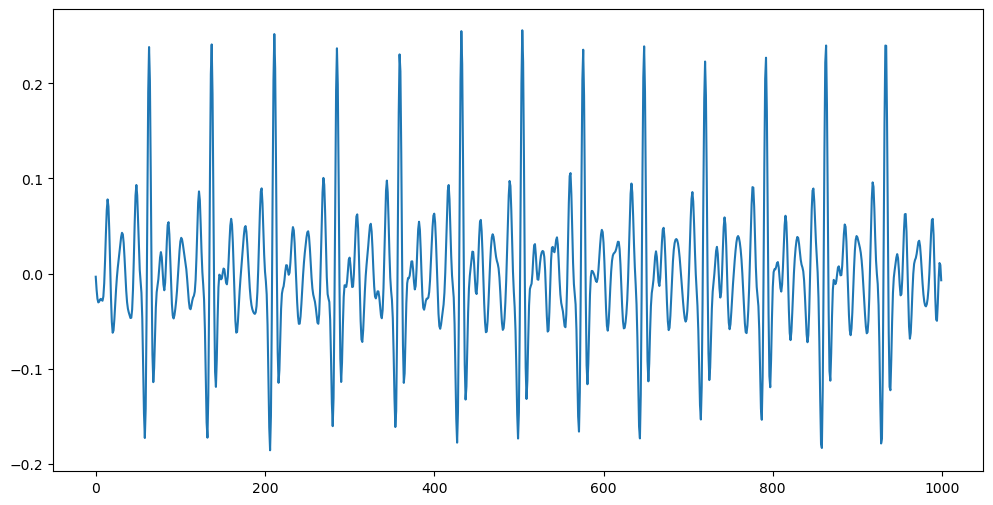

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_signals[1, :, 0])
plt.show()

### Applying the remaining steps of the Pan-Tompkins Algorithm

In [18]:
# Initialize arrays for each step
derivative = np.zeros_like(filtered_signals)
squared = np.zeros_like(filtered_signals)
integrated = np.zeros_like(filtered_signals)

n_signals, n_samples, _ = filtered_signals.shape
window_size = int(0.150 * fs)  # 150 ms window

for i in range(n_signals):
    # Derivative
    derivative[i, :-1, 0] = np.diff(filtered_signals[i, :, 0])

    # Squaring
    squared[i, :, 0] = np.square(derivative[i, :, 0])

    # Moving window integration
    integrated[i, :, 0] = np.convolve(squared[i, :, 0], np.ones(window_size), mode='same')


<span style="color: red; font-size: 150%;">$\text{After applying Derivative Filter, Squaring, Integration}$</span>

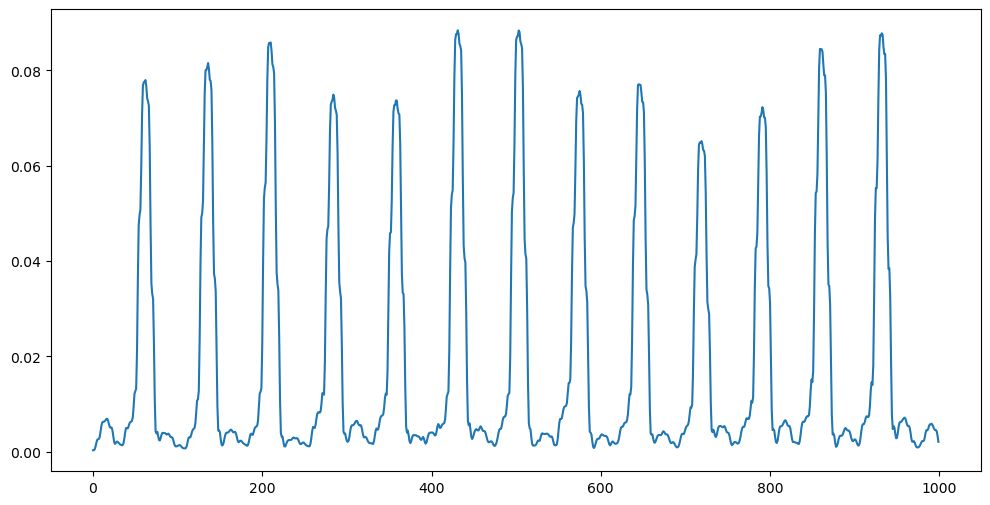

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(integrated[1, :, 0])
plt.show()

### Peak Detection

In [19]:
# initialize a list to store the R-peaks for each signal
r_peaks_all_signals = []

for i in range(n_signals):
    # find peaks on the integrated signal
    peaks, _ = find_peaks(integrated[i, :, 0], height=np.max(integrated[i, :, 0])*0.5, distance=fs*0.6)

    # Append the detected peaks to the list
    r_peaks_all_signals.append(peaks)

In [20]:
peak_counts = [len(sublist) for sublist in r_peaks_all_signals]

In [ ]:
# plot_signals(filtered_signals, r_peaks_all_signals)

### Extracting ST Segments

In [21]:
def extract_st_segments(ecg_signals, r_peaks_all, fs, st_duration=0.08, st_start_offset=0.06):
    """
    Extracts the ST segments from multiple ECG signals.

    :param ecg_signals: List of ECG signals, each being a 1D numpy array.
    :param r_peaks_all: 2D list of R-peaks indices for each ECG signal.
    :param fs: Sampling frequency of the ECG signals.
    :param st_duration: Duration of the ST segment in seconds (default is 80 ms).
    :param st_start_offset: Offset from the R-peak to start of ST segment in seconds (default is 60 ms).
    :return: 2D list of ST segment mean values for each individual.
    """

    all_st_segments = []

    for i, ecg_signal in enumerate(ecg_signals):
        st_segments = []
        for r_peak in r_peaks_all[i]:
            # calculate start and end indices of the ST segment
            st_start = int(r_peak + st_start_offset * fs)
            st_end = int(st_start + st_duration * fs)

            # ensure that the end index does not exceed the signal length
            if st_end > len(ecg_signal):
                continue

            # extracting the ST segment
            st_segment = ecg_signal[st_start:st_end]

            # calculate a feature of the ST segment, e.g., mean amplitude
            st_feature = np.mean(st_segment)
            st_segments.append(st_feature)
        
        all_st_segments.append(st_segments)

    return all_st_segments


<span style="color: blue; font-size: 120%;">$\text{We extract multiple ST segment mean value for each subject since there are multiple ST segments in each ECG signal}$</span>

In [22]:
st_segment_features =[]
for i in range(n_signals):
    # find peaks on the integrated signal
    st_segment_feature = extract_st_segments(filtered_signals, r_peaks_all_signals, 100)

    # Append the detected peaks to the list
    st_segment_features.append(st_segment_feature)

In [ ]:
st_segment_features

In [36]:
def calculate_feature_mean(input_list, feature_name):
    feature_averages = []

    # Iterate through qrs_areas and find the size of each sublist
    for sublist in input_list:
        feature_average = sum(sublist) / len(sublist) if len(sublist) > 0 else 0  # Calculate the average
        feature_averages.append(feature_average)

    #for i, average in enumerate(feature_averages):
        #print(f"Average of {feature_name} in ECG {i + 1}: {average}")
        
    return feature_averages

In [ ]:
#calculate_feature_mean(st_segment_features, 'ST Segments')

### Extracting the QRS Features

In [24]:
def find_q_point(signal, r_peak, window_size):
    for i in range(r_peak, r_peak - window_size, -1):
        if i == 0:
            return 0
        if signal[i] > signal[i-1]:  # detecting the change in slope
            return i
    return r_peak - window_size

def find_s_point(signal, r_peak, window_size):
    for i in range(r_peak, r_peak + window_size):
        if i == len(signal) - 1:
            return len(signal) - 1
        if signal[i] > signal[i+1]:  # detecting the change in slope
            return i
    return r_peak + window_size

def extract_qrs_features(ecg_signals, r_peaks, window_size=20):  # window_size depends on fs=100Hz
    qrs_durations = []
    qrs_areas =[]
    for i, signal in enumerate(ecg_signals):
        qrs_duration = []
        qrs_area=[]
        for r_peak in r_peaks[i]:
            q_point = find_q_point(signal, r_peak, window_size)
            s_point = find_s_point(signal, r_peak, window_size)

            qrs_dur = s_point - q_point

            # Area under the curve
            qrs_area_value = np.trapz(signal[q_point:s_point+1], dx=1, axis=0)
            
            qrs_duration.append(qrs_dur)
            qrs_area.append(qrs_area_value)
            
        qrs_durations.append(qrs_duration)
        qrs_areas.append(qrs_area)
    return qrs_durations, qrs_areas

#### not sure if the qrs_areas are correct

In [25]:
qrs_durations, qrs_areas = extract_qrs_features(filtered_signals, r_peaks_all_signals)  # window size is 20 samples

### QRS durations for the each R peak detected in the ECG signal for all subjects:

In [37]:
qrs_dur_averages=calculate_feature_mean(qrs_durations, 'QRS Durations')

In [38]:
qrs_area_averages=calculate_feature_mean(qrs_areas, 'QRS Areas')

### Machine Learning:

In [28]:
ml_df = pd.DataFrame({'QRS Duration Average':  qrs_dur_averages})
ml_df['QRS Area Averages'] = qrs_area_averages
ml_df['Number of R Peaks'] = peak_counts
ml_df['labels'] = labels

In [29]:
def modify_list(lst):
    if 'MI' in lst:
        return ['MI']
    else:
        return lst

# apply the function to the column
ml_df['labels'] = ml_df['labels'].apply(modify_list)

In [31]:
ml_df['labels_str'] = ml_df['labels'].apply(lambda x: ', '.join(x))

# Apply the function to create a new column
ml_df = ml_df.drop('labels', axis=1)

In [32]:
ml_df

,QRS Duration Average,QRS Area Averages,Number of R Peaks,labels_str
0,0.666667,[0.24074308505092143],15,NORM
1,1.384615,[0.24560156069062808],13,NORM
2,0.555556,[0.11581294733639089],9,MI
3,0.461538,[0.13536620194997873],13,MI
4,0.769231,[0.27284155432941243],13,NORM
5,1.166667,[0.08496074719262092],12,NORM
6,0.076923,[0.02772574518010367],13,NORM
7,5.071429,[0.026019749864078533],14,MI
8,0.375000,[0.1068654445838938],8,MI
9,1.500000,[1.0497622197757503],2,MI


In [33]:
# Load your data here
features = ml_df.drop('labels_str', axis=1)  # Features
labels= ml_df['labels_str']  # Labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=3)

# Create a logistic regression model
model_1 = LogisticRegression()

# Train the model
model_1.fit(X_train, y_train)

LogisticRegression()

In [44]:
# results not changing

In [34]:
# Predict on the test set
predictions = model_1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.5


In [35]:
predictions

array(['NORM', 'MI', 'NORM', 'NORM', 'MI', 'MI', 'NORM', 'NORM', 'MI',
       'NORM'], dtype=object)

In [39]:
y_test

20      MI
17      MI
5     NORM
14      MI
28    NORM
27    NORM
4     NORM
15      MI
2       MI
18    NORM
Name: labels_str, dtype: object

### The below cell will be tested later

In [ ]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass